# 🙈 Monkey-patching


In [ ]:
# |default_exp patch

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()

In [ ]:
# |hide
import os
from nbdev.showdoc import *
from fastcore.test import test_eq, test

In [ ]:
# |hide
# For testing, I want to see 8 CPU devices.
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

In [ ]:
# |hide
# |export

import numpy as np
import jax
import jax.numpy as jnp
from jax._src import array
from fastcore.foundation import patch_to
import matplotlib.pyplot as plt

from lovely_jax.repr_str import StrProxy
from lovely_jax.repr_rgb import RGBProxy
from lovely_jax.repr_plt import PlotProxy
from lovely_jax.repr_chans import ChanProxy

In [ ]:
# |export
def _monkey_patch(cls):
    "Monkey-patch lovely features into `cls`" 

    if not hasattr(cls, '_plain_repr'):
        cls._plain_repr = cls.__repr__
        cls._plain_str = cls.__str__
        cls._plain_format = cls.__format__

    @patch_to(cls)
    def __repr__(self: jax.Array):
        return str(StrProxy(self))
    
    # __str__ is used when you do print(), and gives a less detailed version of the object.
    # __repr__ is used when you inspect an object in Jupyter or VSCode, and gives a more detailed version.
    # I think we want to patch both.
    @patch_to(cls)
    def __str__(self: jax.Array):
        return str(StrProxy(self))

    # Without this, the native __format__ will call into numpy formatter
    # and will produce raw numbers. Idea: A way to pass fmt through?
    @patch_to(cls)
    def __format__(self: jax.Array, tmp: str):
        return str(StrProxy(self))

    # Plain - the old behavior
    @patch_to(cls, as_prop=True)
    def p(self: jax.Array):
        return StrProxy(self, plain=True)

    # Verbose - print both stats and plain values
    @patch_to(cls, as_prop=True)
    def v(self: jax.Array):
        return StrProxy(self, verbose=True)

    @patch_to(cls, as_prop=True)
    def deeper(self: jax.Array):
        return StrProxy(self, depth=1)

    @patch_to(cls, as_prop=True)
    def rgb(t: jax.Array):
        return RGBProxy(t)
    
    @patch_to(cls, as_prop=True)
    def chans(t: jax.Array):
        return ChanProxy(t)

    @patch_to(cls, as_prop=True)
    def plt(t: jax.Array):
        return PlotProxy(t)


def monkey_patch():
    _monkey_patch(array.ArrayImpl)
    _monkey_patch(array.DeviceArray)
    _monkey_patch(jax.pxla._ShardedDeviceArray)

In [ ]:
monkey_patch()

In [ ]:
image = jnp.load("mysteryman.npy").transpose(1,2,0)

In [ ]:
spicy = image[0,:12,0].copy()

spicy = (spicy  .at[0].mul(10000)
                .at[1].divide(10000)
                .at[2].set(float('inf'))
                .at[3].set(float('-inf'))
                .at[4].set(float('nan'))
                .reshape((2,6)))

spicy

Array[2, 6] n=12 x∈[-3.541e+03, -3.369e-05] μ=-393.776 σ=1.113e+03 +Inf! -Inf! NaN! cpu:0

In [ ]:
spicy.v # Verbose

Array[2, 6] n=12 x∈[-3.541e+03, -3.369e-05] μ=-393.776 σ=1.113e+03 +Inf! -Inf! NaN! cpu:0
Array([[-3.5405432e+03, -3.3692955e-05,            inf,           -inf,
                   nan, -4.0542859e-01],
       [-4.2255333e-01, -4.9105233e-01, -5.0817710e-01, -5.5955136e-01,
        -5.4242659e-01, -5.0817710e-01]], dtype=float32)

In [ ]:
spicy.p # Plain

Array([[-3.5405432e+03, -3.3692955e-05,            inf,           -inf,
                   nan, -4.0542859e-01],
       [-4.2255333e-01, -4.9105233e-01, -5.0817710e-01, -5.5955136e-01,
        -5.4242659e-01, -5.0817710e-01]], dtype=float32)

In [ ]:
# |hide

f"{spicy}"

'Array[2, 6] n=12 x∈[-3.541e+03, -3.369e-05] μ=-393.776 σ=1.113e+03 \x1b+Inf!\x1b \x1b-Inf!\x1b \x1bNaN!\x1b cpu:0'

In [ ]:
image.deeper

Array[196, 196, 3] n=115248 x∈[-2.118, 2.640] μ=-0.388 σ=1.073 cpu:0
  Array[196, 3] n=588 x∈[-1.912, 2.411] μ=-0.728 σ=0.519 cpu:0
  Array[196, 3] n=588 x∈[-1.861, 2.359] μ=-0.778 σ=0.450 cpu:0
  Array[196, 3] n=588 x∈[-1.758, 2.379] μ=-0.838 σ=0.437 cpu:0
  Array[196, 3] n=588 x∈[-1.656, 2.466] μ=-0.878 σ=0.415 cpu:0
  Array[196, 3] n=588 x∈[-1.717, 2.448] μ=-0.882 σ=0.399 cpu:0
  Array[196, 3] n=588 x∈[-1.717, 2.431] μ=-0.905 σ=0.408 cpu:0
  Array[196, 3] n=588 x∈[-1.563, 2.448] μ=-0.859 σ=0.416 cpu:0
  Array[196, 3] n=588 x∈[-1.475, 2.431] μ=-0.791 σ=0.463 cpu:0
  Array[196, 3] n=588 x∈[-1.526, 2.429] μ=-0.759 σ=0.499 cpu:0
  ...

In [ ]:
dt = image[:3,:5,:3]
dt.deeper(3)

Array[3, 5, 3] n=45 x∈[-1.316, -0.197] μ=-0.593 σ=0.302 cpu:0
  Array[5, 3] n=15 x∈[-0.985, -0.197] μ=-0.491 σ=0.267 cpu:0
    Array[3] x∈[-0.672, -0.197] μ=-0.408 σ=0.197 cpu:0 [-0.354, -0.197, -0.672]
    Array[3] x∈[-0.985, -0.197] μ=-0.507 σ=0.343 cpu:0 [-0.337, -0.197, -0.985]
    Array[3] x∈[-0.881, -0.303] μ=-0.530 σ=0.252 cpu:0 [-0.405, -0.303, -0.881]
    Array[3] x∈[-0.776, -0.303] μ=-0.506 σ=0.199 cpu:0 [-0.440, -0.303, -0.776]
    Array[3] x∈[-0.916, -0.215] μ=-0.506 σ=0.298 cpu:0 [-0.388, -0.215, -0.916]
  Array[5, 3] n=15 x∈[-1.212, -0.232] μ=-0.609 σ=0.302 cpu:0
    Array[3] x∈[-0.724, -0.250] μ=-0.460 σ=0.197 cpu:0 [-0.405, -0.250, -0.724]
    Array[3] x∈[-1.072, -0.232] μ=-0.576 σ=0.360 cpu:0 [-0.423, -0.232, -1.072]
    Array[3] x∈[-0.968, -0.338] μ=-0.599 σ=0.268 cpu:0 [-0.491, -0.338, -0.968]
    Array[3] x∈[-0.968, -0.408] μ=-0.651 σ=0.235 cpu:0 [-0.577, -0.408, -0.968]
    Array[3] x∈[-1.212, -0.408] μ=-0.761 σ=0.336 cpu:0 [-0.662, -0.408, -1.212]
  Array[5, 3] n=

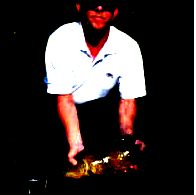

In [ ]:
image.rgb

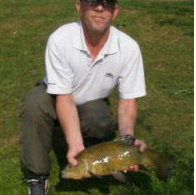

In [ ]:
in_stats = ( (0.485, 0.456, 0.406),     # mean 
             (0.229, 0.224, 0.225) )    # std
image.rgb(in_stats)

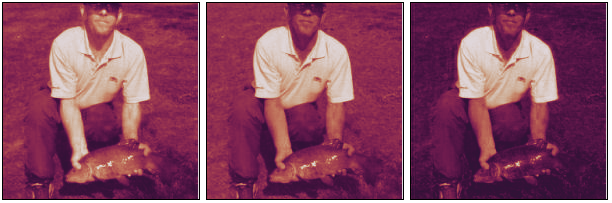

In [ ]:
# |hide

mean = jnp.array(in_stats[0])
std = jnp.array(in_stats[1])

(image*std + mean).chans # all pixels in [0, 1] range

In [ ]:
(image*0.3+0.5) # Slightly outside of [0, 1] range

Array[196, 196, 3] n=115248 x∈[-0.135, 1.292] μ=0.384 σ=0.322 cpu:0

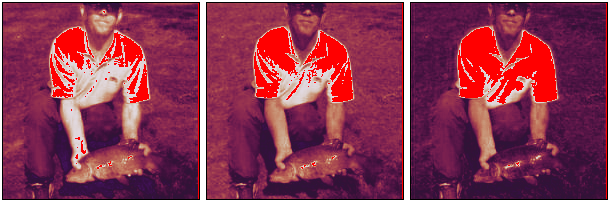

In [ ]:
(image*0.3+0.5).chans # shows clipping (bright blue/red)

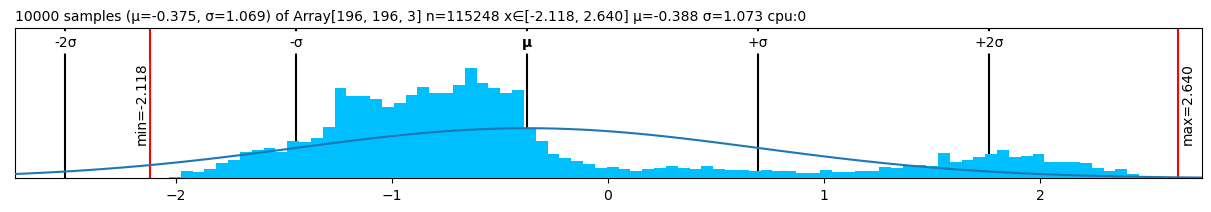

In [ ]:
image.plt

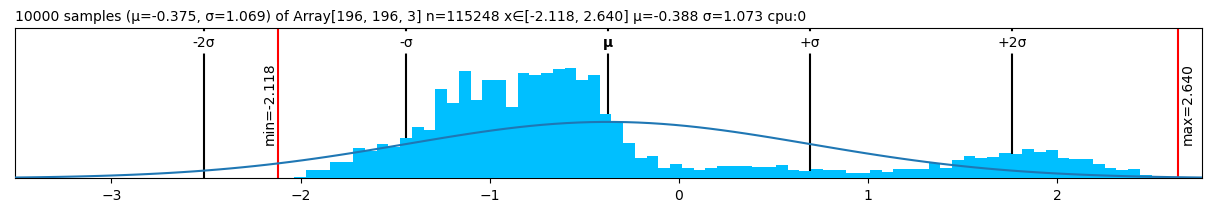

In [ ]:
image.plt(center="mean")

In [ ]:
# |hide
import matplotlib

In [ ]:
# |hide
np.random.seed(1)
matplotlib.rcParams["svg.hashsalt"] = "1"
%config InlineBackend.print_figure_kwargs = {'metadata': {"Date": None, "Creator": "Matplotlib, https://matplotlib.org/" }}

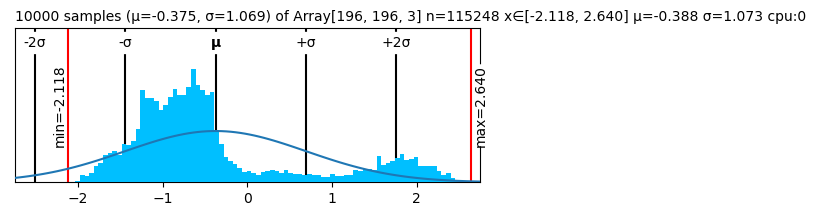

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
plt.close(fig)
image.plt(ax=ax)
fig